# Explore the Autoregressive ++ experiments

In [59]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jovyan/ml_drought


In [60]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

data_dir = Path('data/')

assert data_dir.exists()

In [61]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.utils import get_ds_mask

In [62]:
TRUE_EXPERIMENT = 'one_month_forecast_boku_VCI'
TARGET_VAR =      'boku_VCI'

# EXPERIMENT =      'one_month_forecast_BOKU_boku_VCI_our_vars'
experiment_names = ['ar', 'ar_dynamic', 'ar_dynamic_static']

experiments = [
    "2020_02_17:122024_one_month_forecast_boku_VCI_NOstatic_boku_VCI",
    "2020_02_17:123014_one_month_forecast_boku_VCI_precip_t2m_pet_E_SMroot_SMsurf_NOstatic_boku_VCI",
    "2020_02_17:123856_one_month_forecast_boku_VCI_precip_t2m_pet_E_SMroot_SMsurf_YESstatic_boku_VCI",
]

# Read in the data

In [63]:
X_train, y_train = read_train_data(data_dir, experiment=TRUE_EXPERIMENT)
X_test, y_test = read_test_data(data_dir, experiment=TRUE_EXPERIMENT)
static_ds = xr.open_dataset(data_dir / "features/static/data.nc")

ds = xr.merge([y_train, y_test]).sortby('time').sortby('lat')
d_ = xr.merge([X_train, X_test]).sortby('time').sortby('lat')
ds = xr.merge([ds, d_])

In [64]:
print("TRAINING DATA")
display(ds)
print('\n\n')
print("TARGET DATA")
display(y_test)

TRAINING DATA


<xarray.Dataset>
Dimensions:     (lat: 45, lon: 35, time: 205)
Coordinates:
  * time        (time) datetime64[ns] 2001-12-31 2002-01-31 ... 2018-12-31
  * lat         (lat) float32 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.25 5.5 5.75 6.0
  * lon         (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
Data variables:
    boku_VCI    (time, lat, lon) float64 100.0 100.0 98.82 ... 11.94 78.34 40.51
    VCI3M       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    modis_ndvi  (time, lat, lon) float64 0.688 0.5456 0.7328 ... nan nan nan
    VCI         (time, lat, lon) float64 57.69 89.55 63.82 45.12 ... nan nan nan
    precip      (time, lat, lon) float64 102.0 107.6 122.3 111.1 ... nan nan nan
    E           (time, lat, lon) float64 85.9 60.61 60.61 57.43 ... nan nan nan
    Eb          (time, lat, lon) float64 3.518 1.266 1.266 2.995 ... nan nan nan
    SMroot      (time, lat, lon) float64 0.2638 0.2245 0.2245 ... nan nan nan
    SMsurf      (time, lat, lon) float64 0.2978 0.2648 0.2648 ... nan nan nan
    p84.162     (time, lat, lon) float64 1.45e-05 -5.456e-05 ... nan nan
    pev         (time, lat, lon) float64 -0.005993 -0.006077 ... nan nan
    sp          (time, lat, lon) float64 8.862e+04 8.927e+04 ... nan nan
    t2m         (time, lat, lon) float64 297.5 298.4 297.4 296.2 ... nan nan nan
    tp          (time, lat, lon) float64 0.003657 0.00285 0.004386 ... nan nan




TARGET DATA


<xarray.Dataset>
Dimensions:   (lat: 45, lon: 35, time: 36)
Coordinates:
  * lat       (lat) float32 6.0 5.75 5.5 5.25 5.0 ... -4.0 -4.25 -4.5 -4.75 -5.0
  * lon       (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
  * time      (time) datetime64[ns] 2016-01-31 2016-02-29 ... 2018-12-31
Data variables:
    boku_VCI  (time, lat, lon) float64 64.45 52.16 97.37 96.48 ... nan nan nan

# Load in Predictions

In [65]:
from src.utils import get_ds_mask
mask = get_ds_mask(X_train.VCI)

bline = False

model_dict = {}
for EXPERIMENT, experiment_name in zip(experiments, experiment_names):
    model_dict[experiment_name] = {}
    lstm_pred = read_pred_data('rnn', data_dir, experiment=EXPERIMENT)[-1].where(~mask)
    model_dict[experiment_name]['lstm_pred'] = lstm_pred
    
    # did we run persistence?
    if bline:
        bline_pred = read_pred_data('previous_month', data_dir, experiment=EXPERIMENT)[-1].where(~mask)
        model_dict[experiment_name]['bline_pred'] = bline_pred
    
    # did we run ealstm?
    if 'static' in experiment_name: 
        ealstm_pred = read_pred_data('ealstm', data_dir, experiment=EXPERIMENT)[-1].where(~mask)
        model_dict[experiment_name]['ealstm_pred'] = ealstm_pred

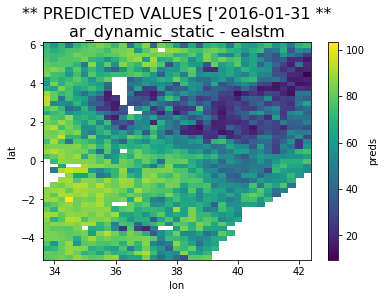

In [66]:
fig, ax = plt.subplots()
time_ix = 0

experiment_name = 'ar_dynamic_static'
time = model_dict[experiment_name]['ealstm_pred'].time.values
model_dict[experiment_name]['ealstm_pred'].isel(time=time_ix).plot(ax=ax)
ax.set_title(f"** PREDICTED VALUES {str(time).split('T')[0]} **\n{experiment_name} - ealstm", size=16);

# How did the experiments go?

In [67]:
print(TARGET_VAR)
print(experiment_names)
print(y_test.time.min().values, y_test.time.max().values)

boku_VCI
['ar', 'ar_dynamic', 'ar_dynamic_static']
2016-01-31T00:00:00.000000000 2018-12-31T00:00:00.000000000


In [68]:
from src.analysis import annual_scores

In [69]:
scores_dict = {}

for EXPERIMENT, experiment_name in zip(experiments, experiment_names):
    # load the monthly scores dictionary
    monthly_scores = annual_scores(
        data_path=data_dir,
        models=['rnn', 'ealstm'] if 'static' in experiment_name else ['rnn'],
        metrics=['rmse', 'r2'],
        pred_years=[y for y in range(2016, 2019)],
        experiment=EXPERIMENT,
        true_data_experiment=TRUE_EXPERIMENT,
        target_var=TARGET_VAR,
        verbose=False,
        to_dataframe=True
    )
    monthly_scores['time'] = monthly_scores.apply(lambda row: pd.to_datetime(f"{int(row.month)}-{int(row.year)}"), axis=1)
    
    # store the result to a dictionary
    scores_dict[experiment_name] = monthly_scores

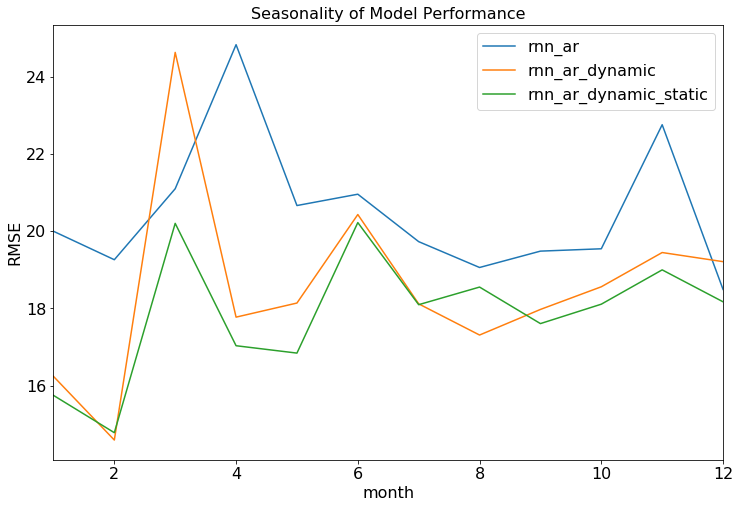

In [70]:
fig, ax = plt.subplots(figsize=(12, 8))
for experiment_name in experiment_names:
    monthly_scores = scores_dict[experiment_name]
    
    for model in ['rnn']: # 
        (
            monthly_scores
            .where(monthly_scores.metric == 'rmse')
            .groupby('month').mean().reset_index()
            # .rename(columns={model: f'{model}_{experiment_name}'})
            .plot(x='month', y=model, label=f'{model}_{experiment_name}', ax=ax)
        )
    
    plt.legend(fontsize=16)
    ax.set_title('Seasonality of Model Performance')
    ax.set_ylabel('RMSE');
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] 
                 + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(16)

# Pixel Wise Performances

In [71]:
experiment_name = 'ar'
models = [k for k in model_dict[experiment_name].keys()]
model = models[0]

model_dict[experiment_name][model]

<xarray.DataArray 'preds' (time: 36, lat: 45, lon: 35)>
dask.array<where, shape=(36, 45, 35), dtype=float32, chunksize=(1, 45, 35), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.0 5.25 5.5 5.75 6.0
  * lon      (lon) float64 33.75 34.0 34.25 34.5 34.75 ... 41.5 41.75 42.0 42.25
  * time     (time) datetime64[ns] 2016-01-31 2016-02-29 ... 2018-12-31

### View the Distributions

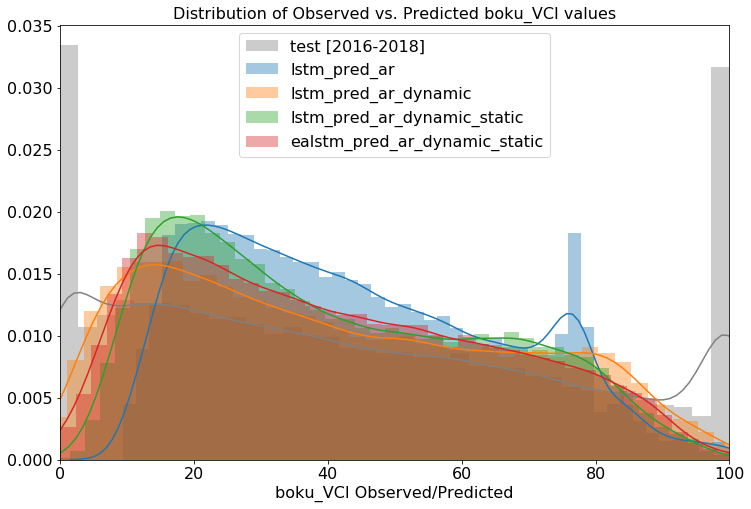

In [72]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(drop_nans_and_flatten(y_test[TARGET_VAR]), ax=ax, label='test [2016-2018]', color='grey')

for experiment_name in experiment_names:
    models = [k for k in model_dict[experiment_name].keys()]
    for model in models:
        sns.distplot(drop_nans_and_flatten(model_dict[experiment_name][model]), ax=ax, label=f'{model}_{experiment_name}')

ax.set_xlim([0, 100])
plt.legend(fontsize=16)
ax.set_xlabel(f'{TARGET_VAR} Observed/Predicted');
ax.set_title(f'Distribution of Observed vs. Predicted {TARGET_VAR} values');

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] 
             + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

### View the mean performances

In [73]:
models = [k for k in model_dict[experiment_name].keys()]
models

['lstm_pred', 'ealstm_pred']

In [74]:
from src.analysis import spatial_rmse, spatial_r2

rmse_dict = {}
r2_dict = {}
for experiment_name in experiment_names:
    rmse_dict[experiment_name] = {}
    r2_dict[experiment_name] = {}
    
    # iterate over each model defined for that experiment
    models = [k for k in model_dict[experiment_name].keys()]
    for model in models:
        # ------- RMSE -------
        model_rmse = spatial_rmse(
            y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
            model_dict[experiment_name][model].transpose("time", "lat", "lon")
        )
        rmse_dict[experiment_name][model] = model_rmse
        
        # ------- R2 -------
        model_r2 = spatial_r2(
            y_test[TARGET_VAR].transpose("time", "lat", "lon").sortby(["time", "lat", "lon"]), 
            model_dict[experiment_name][model].transpose("time", "lat", "lon").sortby(["time", "lat", "lon"])
        )
        r2_dict[experiment_name][model] = model_r2


        # calculate mean performance scores
        model_mean = model_rmse.mean().values
        print(f"{experiment_name} {model} mean RMSE: ".ljust(20), f"{model_mean:.2f}")
        
        model_mean = model_r2.mean().values
        print(f"{experiment_name} {model} mean R2: ".ljust(20), f"{model_mean:.2f}")

ar lstm_pred mean RMSE:  20.91
ar lstm_pred mean R2:  0.53
ar_dynamic lstm_pred mean RMSE:  18.74
ar_dynamic lstm_pred mean R2:  0.61
ar_dynamic_static lstm_pred mean RMSE:  18.12
ar_dynamic_static lstm_pred mean R2:  0.64
ar_dynamic_static ealstm_pred mean RMSE:  18.11
ar_dynamic_static ealstm_pred mean R2:  0.64


### How does this look spatially?

In [75]:
experiment_name = 'ar'
model = 'lstm_pred'

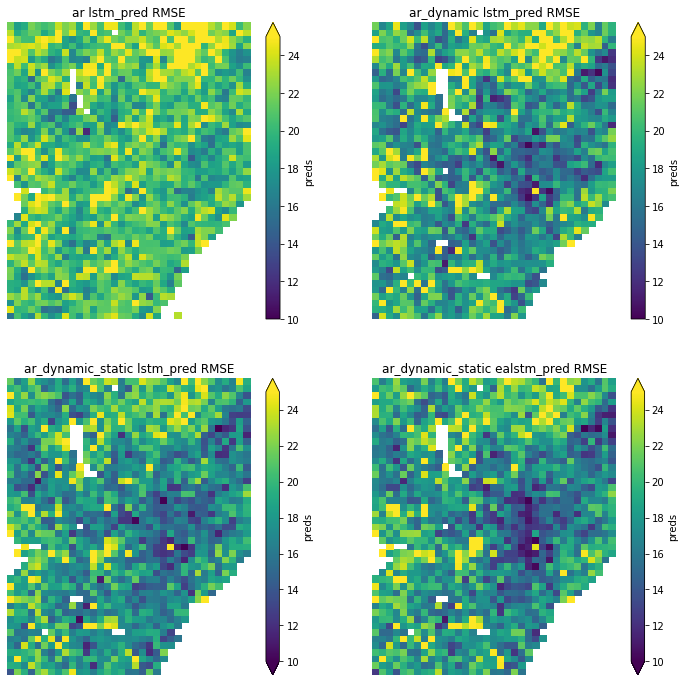

In [76]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))

for ix, (experiment_name, model) in enumerate(
    zip(['ar', 'ar_dynamic', 'ar_dynamic_static', 'ar_dynamic_static'],
        ['lstm_pred', 'lstm_pred', 'lstm_pred', 'ealstm_pred'])
):
    ax_ix = np.unravel_index(ix, (2, 2))
    ax = axs[ax_ix]
    # RMSEs
    kwargs = dict(vmin=10, vmax=25)
    rmse_dict[experiment_name][model].plot(ax=ax, **kwargs)
    ax.axis('off')
    ax.set_title(f'{experiment_name} {model} RMSE')

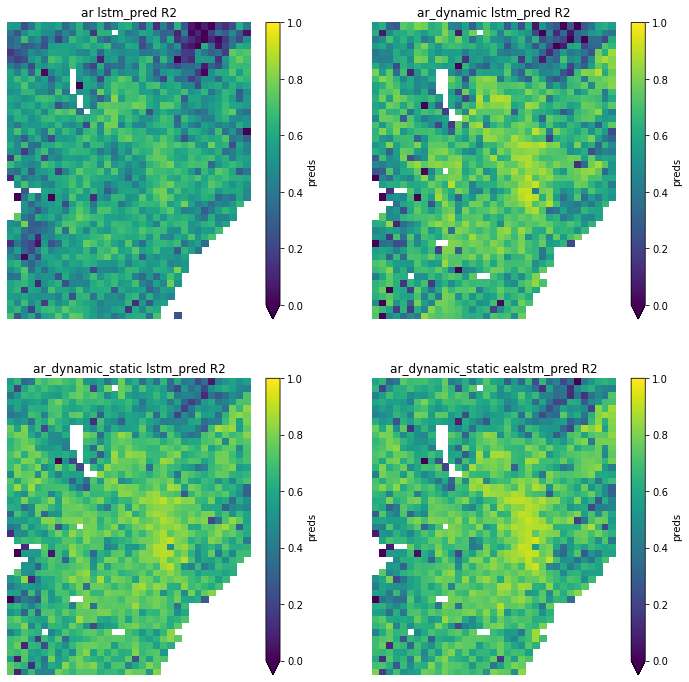

In [77]:
# TODO: spatial_r2 is messing up the axis/dimensions
fig, axs = plt.subplots(2, 2, figsize=(12,12))

for ix, (experiment_name, model) in enumerate(
    zip(['ar', 'ar_dynamic', 'ar_dynamic_static', 'ar_dynamic_static'],
        ['lstm_pred', 'lstm_pred', 'lstm_pred', 'ealstm_pred'])
):
    ax_ix = np.unravel_index(ix, (2, 2))
    ax = axs[ax_ix]
    # RMSEs
    kwargs = dict(vmin=0, vmax=1)
    r2_dict[experiment_name][model].plot(ax=ax, **kwargs)
    ax.axis('off')
    ax.set_title(f'{experiment_name} {model} R2')

### And the overall high level overview?

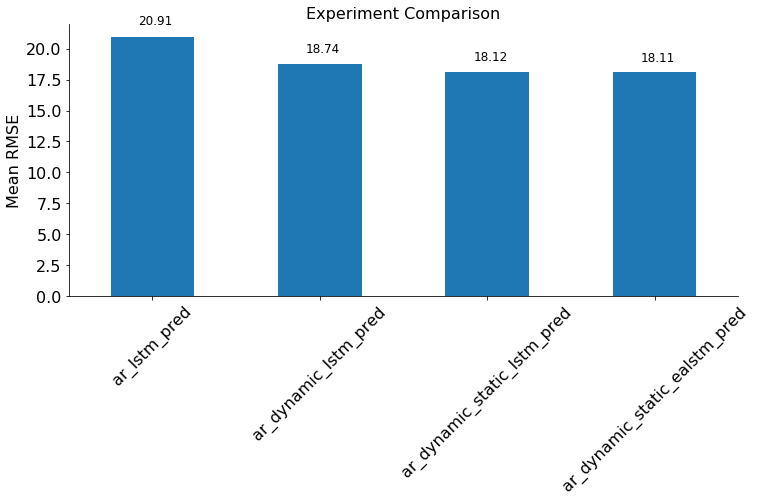

In [78]:
dict_ = {}

for experiment_name in experiment_names:
    models = [k for k in model_dict[experiment_name].keys()]
    for model in models:
        model_rmse = rmse_dict[experiment_name][model]
        dict_[f"{experiment_name}_{model}"] = [np.nanmean(model_rmse.values)]


fig, ax = plt.subplots(figsize=(12, 5))
mean_df = pd.DataFrame(dict_).T.astype(float)
mean_df.plot.bar(ax=ax, legend=False)

ax.set_title('Experiment Comparison: RMSE')
ax.set_ylabel('Mean RMSE');
plt.xticks(rotation=45)

# 
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] 
             + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.2f}",  # annotation (str)
        (p.get_x() + (p.get_width() / 3), p.get_height() * 1.05),  # (x, y) coords
        fontsize=12,
#         fontweight='bold'
    )

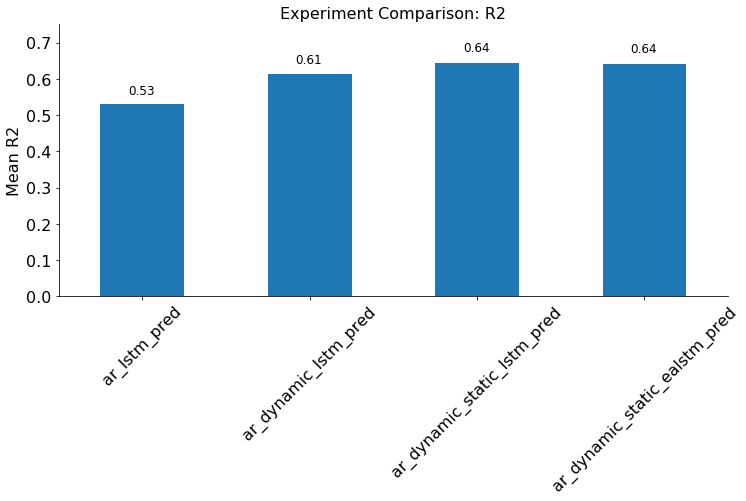

In [81]:
dict_ = {}

for experiment_name in experiment_names:
    models = [k for k in model_dict[experiment_name].keys()]
    for model in models:
        model_r2 = r2_dict[experiment_name][model]
        dict_[f"{experiment_name}_{model}"] = [np.nanmean(model_r2.values)]


fig, ax = plt.subplots(figsize=(12, 5))
mean_df = pd.DataFrame(dict_).T.astype(float)
mean_df.plot.bar(ax=ax, legend=False)

ax.set_title('Experiment Comparison: R2')
ax.set_ylabel('Mean R2');
plt.xticks(rotation=45)

# 
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] 
             + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([0, 0.75])
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.2f}",  # annotation (str)
        (p.get_x() + (p.get_width() / 3), p.get_height() * 1.05),  # (x, y) coords
        fontsize=12,
#         fontweight='bold'
    )

### Check 'drought' forecast ability

    VCI3M Limits   | Description                        | Value
    -----------------------------------------------------------
    0 <= x <10     | Extreme vegetation deficit         |  1
    10 <= x <20    | Severe vegetation deficit          |  2
    20 <= x <35    | Moderate vegetation deficit        |  3
    35 <= x <50    | Normal vegetation conditions       |  4
    50 <= x <=100  | Above normal vegetation conditions |  5


In [93]:
from src.analysis import VegetationDeficitIndex

v = VegetationDeficitIndex(data_dir / 'interim/VCI_preprocessed/data_kenya.nc')
vdi_true = v.vegetation_index_classify(y_test[TARGET_VAR], 'vdi')
vdi_true_np = vdi_true.stack(pixel=['lat', 'lon']).values.flatten().clip(min=1, max=5)

vdi_dict = {}
vdi_np_dict = {}
for experiment_name in experiment_names:
    vdi_dict[experiment_name] = {}
    vdi_np_dict[experiment_name] = {}
    models = [k for k in model_dict[experiment_name].keys()]
    for model in models:
        # classify the predictions into 
        vdi_model_pred = v.vegetation_index_classify(model_dict[experiment_name][model].load(), 'vdi')
        vdi_model_np = vdi_model_pred.stack(pixel=['lat', 'lon']).values.flatten().clip(min=1, max=5)
        vdi_dict[experiment_name][model] = vdi_model_pred
        vdi_np_dict[experiment_name][model] = vdi_model_np

#### Confusion Matrices

In [89]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes=None,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          **imshow_kwargs):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, **imshow_kwargs)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
#            xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[0.00110084 0.21400264 0.32133421 0.18450022 0.27906209]
 [0.00215883 0.17517348 0.28835775 0.19599075 0.3383192 ]
 [0.00258793 0.13998353 0.26314551 0.21056346 0.38371956]
 [0.00152566 0.10887656 0.24882108 0.21040222 0.43037448]
 [0.00110149 0.07439024 0.19445319 0.19103068 0.53902439]]


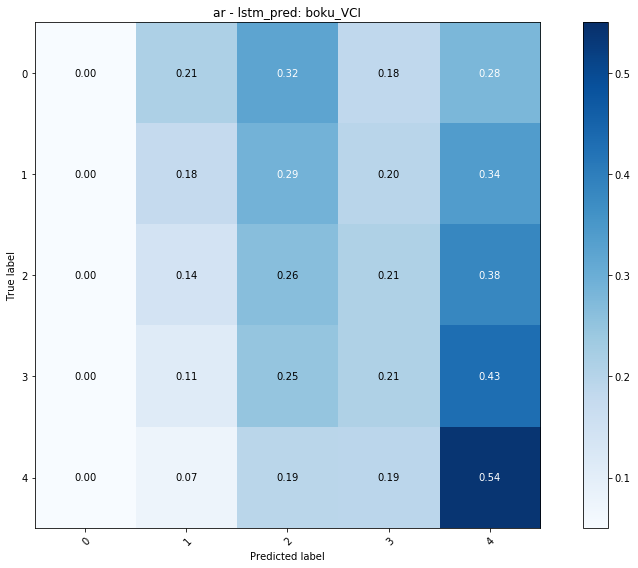

In [103]:
show_all = False

for experiment_name in experiment_names:
    models = [k for k in vdi_np_dict[experiment_name].keys()]
    for model in models:
        model_np = vdi_np_dict[experiment_name][model]
        plot_confusion_matrix(true_np, model_np.clip(min=1, max=5), classes=None, normalize=True,
                              title=f'{experiment_name} - {model}: {TARGET_VAR}',
                              **{'vmin': 0.05, 'vmax': 0.55});
    if not show_all:
        break

### Classification Accuracy

In [104]:
from sklearn.metrics import accuracy_score

for experiment_name in experiment_names:
    models = [k for k in vdi_np_dict[experiment_name].keys()]
    for model in models:
        model_np = vdi_np_dict[experiment_name][model]
        print(f"{experiment_name} {model} classification accuracy:")
        print(f"{accuracy_score(vdi_true_np, model_np, normalize=True):.2f}", "\n")

ar lstm_pred classification accuracy:
0.33 

ar_dynamic lstm_pred classification accuracy:
0.35 

ar_dynamic_static lstm_pred classification accuracy:
0.34 

ar_dynamic_static ealstm_pred classification accuracy:
0.34 

